Theoretical orbit response to kick $\theta$:

$$C_{ij} = \theta_i \frac{ \sqrt{\beta_i \beta_j}}{2 \sin{\pi Q}} \cos(  2 \pi | \mu_i - \mu_j| - \pi Q) + \frac{\eta_i \eta_j}{\left( \alpha_C - \frac{1}{\gamma^2}\right) C}$$

LOCO needs to compute

$$M_x = \frac{\partial^2 x_i}{\partial \theta_j \partial k_{1,m}}$$
$$M_y = \frac{\partial^2 y_i}{\partial \theta_j \partial k_{1,m}}$$

where $\{\theta_j\}$ are orbit correctors hor. and vert.

and

$\{ k_{1,m}\}$ are quadrupole normal and skew used for correction, as many as there are power supplies

input:
perturb.param or script generating same
...

In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from AT_ORM import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice2 import *
ring=at.Lattice(ring, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.21808517 0.11816895]
Chrom=[ 1.94950847 -2.27073414]


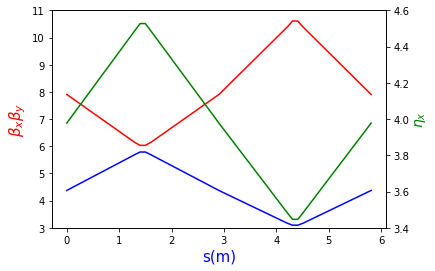

In [5]:
elements_indexes = get_refpts(ring, elements.Monitor)
twiss = getOptics(ring, '*', 'beta', 'False')

(2, 2)


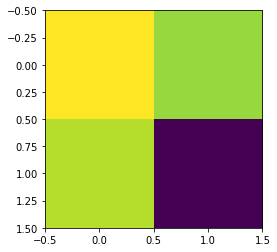

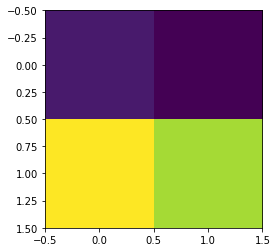

Cxx [[3.538856   3.29592079]
 [3.3608066  1.9463771 ]]
Cxy [[0. 0.]
 [0. 0.]]


In [6]:
Cxx, Cxy= ORM_x(1.e-3, ring)
Cyy, Cyx= ORM_y(1.e-3, ring)


print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyx)
plt.show()

print('Cxx',Cxx)
print('Cxy',Cxy)

In [6]:
quads_info = quad_info(ring)

Done...


In [7]:
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],0])
print(quad_vals[quads[iq],2])
eocc_a, vals = getQuadFamilies(quads_info)
print(eocc_a)
print(quad_vals[quads[iq],3])

Quadrupoles:['QF', 'QD']
QD 19
-2.1
-2.1
{'QF': 19, 'QD': 19}
-2.1


In [8]:
def computeOpticsD(ring, qname, i, dk):

    bpm_indexes = get_refpts(ring, elements.Monitor)
    quad_indexes = get_refpts(ring, qname)

    #print(ring[quad_indexes[i]].K)
    ring[quad_indexes[i]].K =  quad_vals[qname,i] + dk

    qxx, qxy= ORM_x(0.0001, ring)
    qyy, qyx= ORM_y(0.0001, ring)

    ring[quad_indexes[i]].K = quad_vals[qname,i]
    print(ring[quad_indexes[i]].K)
    #print('Done')

    return  qxx, qxy, qyy, qyx

In [9]:
%%time
# sequential version, this takes long:
# optimize with parallelization and separate function
# prepare

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname,i, dk)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

generating response to QF, n=19
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
generating response to QD, n=19
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
Wall time: 2min 56s


In [10]:
from loco import getTheorOrm, getOrm
from pylab import *

C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dk = 0.0001
dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QD


In [14]:
len(dCx)
dCx[0]

array([[-0.19232042, -0.29337036, -0.43793448, ..., -0.19514626,
        -0.43613252, -0.29769472],
       [-0.2838987 , -0.43295781, -0.64615239, ..., -0.28810713,
        -0.64345055, -0.43927442],
       [-0.42424799, -0.64671719, -0.96501085, ..., -0.43048308,
        -0.96086484, -0.65610274],
       ...,
       [-0.18366203, -0.28016216, -0.41814748, ..., -0.18634816,
        -0.41632074, -0.28420623],
       [-0.41900308, -0.63865616, -0.95291951, ..., -0.42492527,
        -0.9491825 , -0.64809182],
       [-0.29717706, -0.45311797, -0.67621077, ..., -0.30146109,
        -0.6735071 , -0.45980335]])

1.0025885855169392


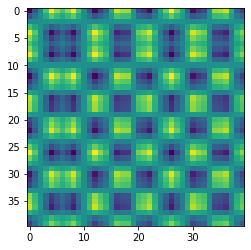

0.0019435986460558143


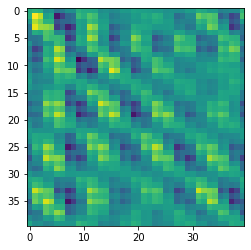

0.25250963352985156


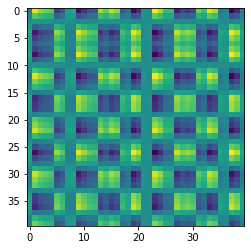

0.009810768486374216


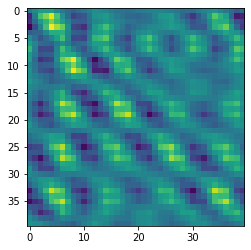

In [11]:
print(np.max(dCx[3]))
plt.imshow(dCx[3])
plt.show()


print(np.max(dCy[3]))
plt.imshow(dCy[3])
plt.show()

print(np.max(dCxy[3]))
plt.imshow(dCxy[3])
plt.show()

print(np.max(dCyx[3]))
plt.imshow(dCyx[3])
plt.show()

In [12]:
## simulate_errors

In [15]:
errorQF = 72.e-3 #0.01
errorQD = 52.e-3 #0.01
#tiltQF = 0.0003
#tiltQD = 0.0003

quads_info_error = simulateError(ring,errorQF,errorQD)

simulating perturbed machine...
Done...


preparing twiss ..
Tunes=[0.39901407 0.38561103]
Chrom=[ 38.69434787 -44.75805885]


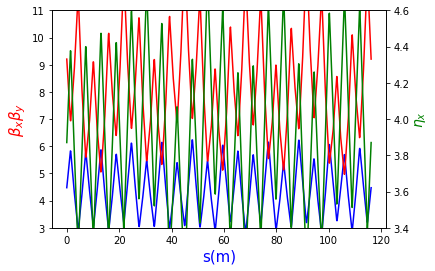

In [16]:
twiss_error = getOptics(ring, '*', 'beta', 'True')

In [15]:
#Cell2

(40, 40)


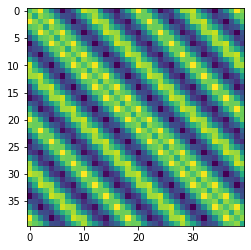

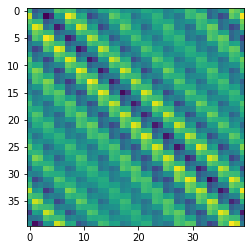

In [17]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyy_err)
plt.show()

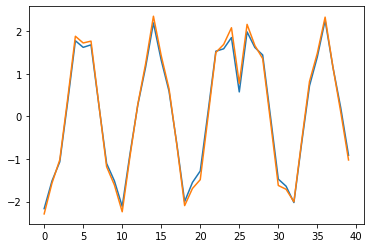

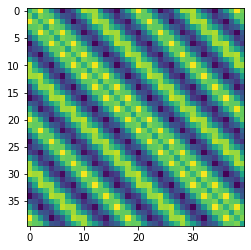

In [18]:
plt.plot(Cxx_err[25])
plt.plot((Cxx[25]))
plt.show()
plt.imshow(Cxx_err)
plt.show()

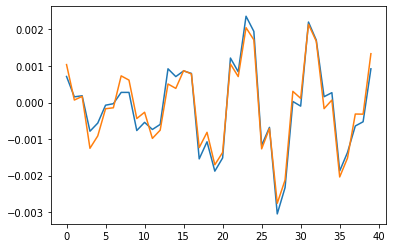

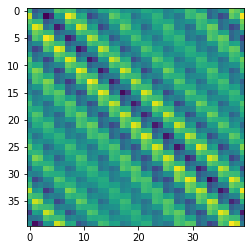

In [19]:
plt.plot(Cyy[25])
plt.plot((Cyy_err[25]))
plt.show()
plt.imshow(Cyy_err)

In [20]:
Cxx

array([[ 1.38038242e+00,  2.09280524e+00,  3.06433032e+00, ...,
         1.42297026e+00,  3.08990671e+00,  2.07058020e+00],
       [ 2.08239046e+00,  7.75623278e-01,  2.16131913e+00, ...,
        -3.07742790e-03,  1.50167223e+00,  1.69043789e+00],
       [ 3.08990671e+00,  2.07058020e+00,  1.38038242e+00, ...,
        -1.50495793e+00, -5.21673803e-02,  1.42297026e+00],
       ...,
       [ 1.35779207e+00, -1.13262333e-01, -1.62093239e+00, ...,
         7.75623278e-01,  2.16131913e+00,  1.66488298e+00],
       [ 3.06433032e+00,  1.38243775e+00, -1.62276545e-01, ...,
         2.07058020e+00,  1.38038242e+00,  2.09280524e+00],
       [ 2.16131913e+00,  1.66488298e+00,  1.35779207e+00, ...,
         1.69043789e+00,  2.08239046e+00,  7.75623278e-01]])

In [21]:
print(np.max(Cxx_err-Cxx))

0.4313456682891518


In [20]:
#Cell4

In [23]:
#A, B = build_matrix(ormx, ormy, C0x, C0x, C0x, dCx, dCy, dCxy, Cyx, ormx, ormy)


Nk = len(dCx) #number of free parameters (number of quads or g_k)
Nm = 40 # number of measurements (iteration) ######### #######
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk]) # (160, 40) ###########


NK: 40
Nm: 40


In [24]:
Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])


In [33]:
Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

In [29]:
Dx.shape

(40, 40)

In [34]:
for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

In [35]:
np.sum(np.dot(dCx[4],dCx[4].T))

76.7897308928735

In [28]:
B.shape

(160, 1)

In [36]:
for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

number of singular values 40
A(160, 40) B(160, 1) U(160, 160) smat(160, 40) v(40, 40)


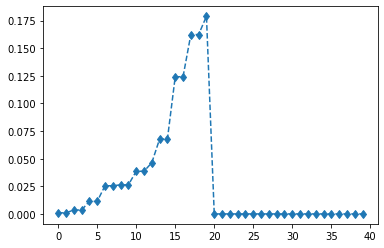

In [37]:
u,s,v=np.linalg.svd(A,  full_matrices=True)

smat = 0.0 * A
si = s**-1
n_sv = 20
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()

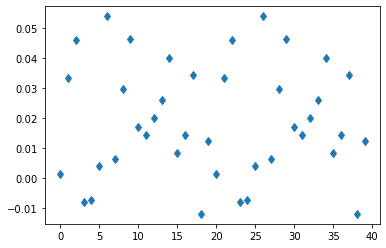

In [38]:
Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()

In [40]:
Ai.shape

(40, 160)

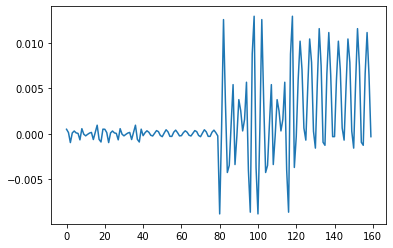

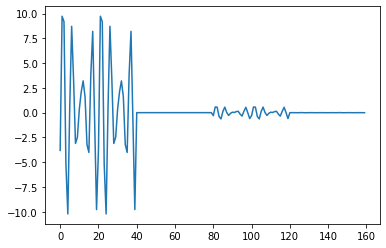

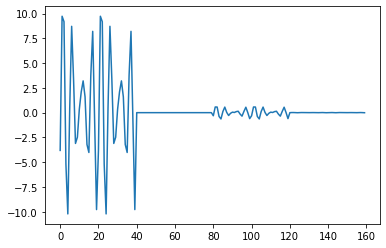

In [43]:
# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()
plt.plot(np.dot(A,r).reshape(-1))
plt.show()


In [44]:
np.dot(A,r).reshape(-1)

array([-3.81152332e+00,  9.73463271e+00,  9.18315470e+00, -5.19391152e+00,
       -1.02245938e+01,  5.00588613e-01,  8.71773234e+00,  3.35705160e+00,
       -3.10853346e+00, -2.47778279e+00,  3.35042678e-01,  2.09227202e+00,
        3.20776715e+00,  1.59841869e+00, -3.21425331e+00, -4.02086138e+00,
        3.74538958e+00,  8.20973002e+00, -6.78705618e-01, -9.78766324e+00,
       -3.81152332e+00,  9.73463271e+00,  9.18315470e+00, -5.19391152e+00,
       -1.02245938e+01,  5.00588613e-01,  8.71773234e+00,  3.35705160e+00,
       -3.10853346e+00, -2.47778279e+00,  3.35042678e-01,  2.09227202e+00,
        3.20776715e+00,  1.59841869e+00, -3.21425331e+00, -4.02086138e+00,
        3.74538958e+00,  8.20973002e+00, -6.78705618e-01, -9.78766324e+00,
       -2.39243326e-04,  5.10760095e-04,  5.03336378e-04, -2.72371518e-04,
       -5.55116817e-04,  4.17157566e-05,  5.09834686e-04,  1.91340028e-04,
       -2.43089998e-04, -2.41320290e-04, -2.19370729e-06,  2.03596873e-04,
        2.51082117e-04,  

In [45]:
B

array([[-3.81201185e+00],
       [ 9.73450572e+00],
       [ 9.18413356e+00],
       [-5.19399721e+00],
       [-1.02248886e+01],
       [ 5.00499797e-01],
       [ 8.71769950e+00],
       [ 3.35772968e+00],
       [-3.10908652e+00],
       [-2.47772753e+00],
       [ 3.35280791e-01],
       [ 2.09234432e+00],
       [ 3.20769830e+00],
       [ 1.59827878e+00],
       [-3.21361057e+00],
       [-4.02100591e+00],
       [ 3.74445407e+00],
       [ 8.21035321e+00],
       [-6.77790676e-01],
       [-9.78816220e+00],
       [-3.81201185e+00],
       [ 9.73450572e+00],
       [ 9.18413356e+00],
       [-5.19399721e+00],
       [-1.02248886e+01],
       [ 5.00499797e-01],
       [ 8.71769950e+00],
       [ 3.35772968e+00],
       [-3.10908652e+00],
       [-2.47772753e+00],
       [ 3.35280791e-01],
       [ 2.09234432e+00],
       [ 3.20769830e+00],
       [ 1.59827878e+00],
       [-3.21361057e+00],
       [-4.02100591e+00],
       [ 3.74445407e+00],
       [ 8.21035321e+00],
       [-6.7

In [27]:
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],1])
print(quad_vals[quads[iq],2])
eocc_a, vals = getQuadFamilies(quads_info_error)
print(eocc_a)
print(quad_vals[quads[iq],3])

Quadrupoles:['QF', 'QD']
QD 20
-2.19423178483569
-2.1020193445274544
{'QF': 20, 'QD': 20}
-2.1337071243451926


In [28]:
# check correction...


n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

40


In [29]:
nquad

20

In [30]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)

In [31]:
r

array([-0.0255156 ,  0.03282277,  0.03662318,  0.01010138, -0.01407176,
        0.00265874,  0.03964094,  0.01876937,  0.00923639,  0.03511832,
        0.04518018,  0.00495023,  0.02409777,  0.04368764, -0.0026744 ,
       -0.00507131, -0.0051245 ,  0.02364477,  0.03981411,  0.01874843,
       -0.0255156 ,  0.03282277,  0.03662318,  0.01010138, -0.01407176,
        0.00265874,  0.03964094,  0.01876937,  0.00923639,  0.03511832,
        0.04518018,  0.00495023,  0.02409777,  0.04368764, -0.0026744 ,
       -0.00507131, -0.0051245 ,  0.02364477,  0.03981411,  0.01874843])

In [32]:
DK

[0.025515596466755497,
 0.02551559646675594,
 -0.032822771128404926,
 -0.03282277112840548,
 -0.03662318230936856,
 -0.03662318230936823,
 -0.010101379485855544,
 -0.010101379485855294,
 0.014071756793722134,
 0.01407175679372219,
 -0.0026587404021012895,
 -0.00265874040210054,
 -0.03964094015567099,
 -0.039640940155670934,
 -0.018769366504484797,
 -0.01876936650448502,
 -0.009236389107424747,
 -0.009236389107424858,
 -0.03511832185744551,
 -0.0351183218574454,
 -0.04518018221169834,
 -0.04518018221169823,
 -0.004950229770978282,
 -0.004950229770977949,
 -0.024097767508286988,
 -0.024097767508286988,
 -0.043687640402421124,
 -0.04368764040242096,
 0.002674404451013579,
 0.0026744044510133014,
 0.005071313267040689,
 0.005071313267040134,
 0.005124499125658488,
 0.005124499125658488,
 -0.02364476942409044,
 -0.02364476942409044,
 -0.03981410670686425,
 -0.03981410670686447,
 -0.018748432516077163,
 -0.018748432516076607]

In [33]:
QF_indexes = get_refpts(ring, 'QF')
QD_indexes = get_refpts(ring, 'QD')
quads_indexes = get_refpts(ring, elements.Quadrupole)

In [34]:
i = 0
while (i < len(quads_indexes)):

      print(ring[quads_indexes[i]].K)
      ring[quads_indexes[i]].K += DK[i]
      print(ring[quads_indexes[i]].K)
      i += 1


1.7086315545070494
1.734147150973805
-2.19423178483569
-2.168716188368934
1.790036157719166
1.7572133865907609
-2.1020193445274544
-2.13484211565586
1.7792863207225855
1.742663138413217
-2.1337071243451926
-2.1703303066545607
1.7480983157247787
1.7379969362389232
-2.1547802602889723
-2.1648816397748276
1.710575734507975
1.7246474913016971
-2.1702031553391437
-2.1561313985454214
1.7309921760880995
1.7283334356859983
-2.12463016581501
-2.1272889062171103
1.795246149215748
1.755605209060077
-2.1582381261212005
-2.1978790662768715
1.7852712564712376
1.7665018899667528
-2.1769350581198936
-2.1957044246243784
1.7459329436843065
1.7366965545768818
-2.1200863835801576
-2.1293227726875825
1.791069590636367
1.7559512687789214
-2.165623194422648
-2.200741516280093
1.8136629190323528
1.7684827368206544
-2.1414158184518612
-2.1865960006635596
1.7449591583312878
1.7400089285603095
-2.1783208586571194
-2.1832710884280973
1.7864359514529788
1.7623381839446919
-2.1332503359380754
-2.1573481034463624
1.

In [35]:
quads_info_error.Quad_strength

0     1.708632
1    -2.194232
2     1.790036
3    -2.102019
4     1.779286
5    -2.133707
6     1.748098
7    -2.154780
8     1.710576
9    -2.170203
10    1.730992
11   -2.124630
12    1.795246
13   -2.158238
14    1.785271
15   -2.176935
16    1.745933
17   -2.120086
18    1.791070
19   -2.165623
20    1.813663
21   -2.141416
22    1.744959
23   -2.178321
24    1.786436
25   -2.133250
26    1.816837
27   -2.173847
28    1.740802
29   -2.169082
30    1.708338
31   -2.106108
32    1.713743
33   -2.194022
34    1.811841
35   -2.199733
36    1.820623
37   -2.152127
38    1.775200
39   -2.191421
Name: Quad_strength, dtype: float64

preparing twiss ..
Tunes=[0.37156273 0.44169115]
Chrom=[ 39.35636836 -44.22377429]


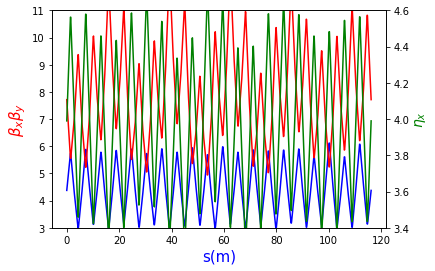

In [36]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

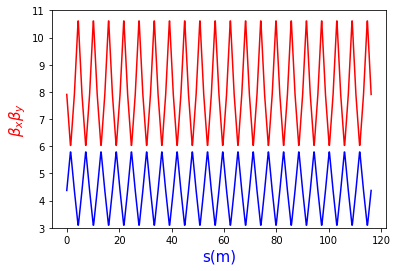

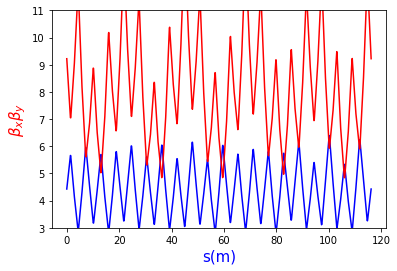

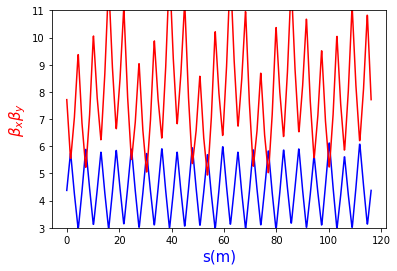

In [37]:

fig, ax = plt.subplots()
ax.plot(twiss.s_pos, twiss.betax, color="blue")
ax.plot(twiss.s_pos, twiss.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()



fig, ax = plt.subplots()
ax.plot(twiss_error.s_pos, twiss_error.betax, color="blue")
ax.plot(twiss_error.s_pos, twiss_error.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


fig, ax = plt.subplots()
ax.plot(twiss_corrected.s_pos, twiss_corrected.betax, color="blue")
ax.plot(twiss_corrected.s_pos, twiss_corrected.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


In [38]:
twiss_error

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.0,0.0,0.0,4.426724,9.221329,0.000000,B1H,1,0
1,1.3,0.0,0.0,5.580264,7.180090,0.000000,CXY,1,0
2,1.3,0.0,0.0,5.580264,7.180090,0.000000,DD,1,0
3,1.4,0.0,0.0,5.661214,7.050952,0.000000,BPM,1,0
4,1.4,0.0,0.0,5.661214,7.050952,1.708632,QF,1,elements.Quadrupole
...,...,...,...,...,...,...,...,...,...
296,114.7,0.0,0.0,3.267532,12.144721,0.000000,BPM,40,0
297,114.7,0.0,0.0,3.267532,12.144721,-2.191421,QD,20,elements.Quadrupole
298,114.8,0.0,0.0,3.257512,12.172353,0.000000,DD,80,0
299,114.9,0.0,0.0,3.325257,11.935677,0.000000,B1H,80,0


In [45]:
twiss_corrected

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.0,0.0,0.0,4.384680,8.341193,0.000000,B1H,1,0
1,1.3,0.0,0.0,5.832624,6.107456,0.000000,CXY,1,0
2,1.3,0.0,0.0,5.832624,6.107456,0.000000,DD,1,0
3,1.4,0.0,0.0,5.937140,5.969801,0.000000,BPM,1,0
4,1.4,0.0,0.0,5.937140,5.969801,1.788242,QF,1,elements.Quadrupole
...,...,...,...,...,...,...,...,...,...
296,114.7,0.0,0.0,3.003330,11.683506,0.000000,BPM,40,0
297,114.7,0.0,0.0,3.003330,11.683506,-2.211571,QD,20,elements.Quadrupole
298,114.8,0.0,0.0,3.006627,11.669357,0.000000,DD,80,0
299,114.9,0.0,0.0,3.083395,11.399901,0.000000,B1H,80,0
